In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import ChiSqSelector
import json

# Reading and Cleaning Training Data


In [ ]:
df = spark.read.table('project.bot_data')
df=df.dropna()
df.printSchema()
df.show(20, False)

root
 |-- id_str: double (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- description: string (nullable = true)
 |-- followers_count: string (nullable = true)
 |-- friends_count: string (nullable = true)
 |-- favourites_count: string (nullable = true)
 |-- verified: string (nullable = true)
 |-- statuses_count: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- default_profile: string (nullable = true)
 |-- default_profile_image: string (nullable = true)
 |-- account_type: string (nullable = true)

+---------------------+---------------+-----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-------------+----------------+--------+--------------+----+---------------+---------------------+------------+
|id_str               |screen_name    |location                    

### Features to detect Twitter Bots:
['followers_count', 'friends_count', 'listedcount', 'favourites_count', 'default_profile', 'word <b>'bot'</b> in the screenname <b>or</b> in the description']

In [ ]:
df.createOrReplaceTempView('df')
raw_df1 = spark.sql('SELECT CAST(screen_name AS string), CAST(description AS string), CAST(verified AS boolean), CAST(followers_count AS LONG), CAST(friends_count AS LONG),\
                         CAST(default_profile AS boolean), CAST(account_type AS INT) FROM df WHERE verified == false')
raw_df1.createOrReplaceTempView('raw_df1')
raw_df = spark.sql('SELECT screen_name, description, followers_count, friends_count,\
                         CAST(default_profile AS INT), account_type FROM raw_df1')
raw_df.printSchema()
raw_df.show(4)

root
 |-- screen_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- default_profile: integer (nullable = true)
 |-- account_type: integer (nullable = true)

+--------------+--------------------+---------------+-------------+---------------+------------+
|   screen_name|         description|followers_count|friends_count|default_profile|account_type|
+--------------+--------------------+---------------+-------------+---------------+------------+
|HoustonPokeMap|Rare and strong P...|           1291|            0|              1|           1|
|     kernyeahx|From late 2014 So...|              1|          349|              1|           1|
|  lucarivera16|Inspiring cooks e...|             11|          745|              0|           1|
|   _all_of_us_|     bot by @rubicon|            193|            0|              0|           1|
+--------------+--------------------+-----------

In [ ]:
raw_df.dropna('any')
raw_df.printSchema()
raw_df.show(4)

root
 |-- screen_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- default_profile: integer (nullable = true)
 |-- account_type: integer (nullable = true)

+--------------+--------------------+---------------+-------------+---------------+------------+
|   screen_name|         description|followers_count|friends_count|default_profile|account_type|
+--------------+--------------------+---------------+-------------+---------------+------------+
|HoustonPokeMap|Rare and strong P...|           1291|            0|              1|           1|
|     kernyeahx|From late 2014 So...|              1|          349|              1|           1|
|  lucarivera16|Inspiring cooks e...|             11|          745|              0|           1|
|   _all_of_us_|     bot by @rubicon|            193|            0|              0|           1|
+--------------+--------------------+-----------

In [ ]:
train_df = raw_df.select( \
'followers_count', 'friends_count', 'default_profile','account_type',
  F.col("screen_name").contains("bot").alias("screen_name_binary"),
  F.col("description").contains("bot").alias("description_name_binary")
).withColumn('bot_binary', F.col('screen_name_binary') | F.col('description_name_binary')).fillna({'bot_binary':False})\
.select('bot_binary', 'followers_count', 'friends_count', 'default_profile', 'account_type')

In [ ]:
train_df.createOrReplaceTempView('train_df')
train_df = spark.sql('SELECT CAST(bot_binary AS INT), followers_count, friends_count, default_profile, account_type FROM train_df')

In [ ]:
train_df.printSchema()
train_df.show()

root
 |-- bot_binary: integer (nullable = false)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- default_profile: integer (nullable = true)
 |-- account_type: integer (nullable = true)

+----------+---------------+-------------+---------------+------------+
|bot_binary|followers_count|friends_count|default_profile|account_type|
+----------+---------------+-------------+---------------+------------+
|         0|           1291|            0|              1|           1|
|         0|              1|          349|              1|           1|
|         0|             11|          745|              0|           1|
|         1|            193|            0|              0|           1|
|         0|             51|            1|              0|           1|
|         0|             15|         1941|              0|           1|
|         0|             23|            4|              0|           1|
|         1|         106126|            0|       

# Scalerizing the features

In [ ]:
train_df=train_df.na.drop('any')

In [ ]:
cols=train_df.columns
cols.remove("account_type")
assembler = VectorAssembler(inputCols=cols,outputCol="features")

In [ ]:
train_df = assembler.transform(train_df)

In [ ]:
train_df.select("features").show(10, truncate=False)

+----------------------+
|features              |
+----------------------+
|[0.0,1291.0,0.0,1.0]  |
|[0.0,1.0,349.0,1.0]   |
|[0.0,11.0,745.0,0.0]  |
|[1.0,193.0,0.0,0.0]   |
|[0.0,51.0,1.0,0.0]    |
|[0.0,15.0,1941.0,0.0] |
|[0.0,23.0,4.0,0.0]    |
|[1.0,106126.0,0.0,1.0]|
|[1.0,2302.0,3.0,0.0]  |
|[1.0,443.0,2.0,0.0]   |
+----------------------+
only showing top 10 rows



In [ ]:
train_df.show(5, truncate=False)

+----------+---------------+-------------+---------------+------------+--------------------+
|bot_binary|followers_count|friends_count|default_profile|account_type|features            |
+----------+---------------+-------------+---------------+------------+--------------------+
|0         |1291           |0            |1              |1           |[0.0,1291.0,0.0,1.0]|
|0         |1              |349          |1              |1           |[0.0,1.0,349.0,1.0] |
|0         |11             |745          |0              |1           |[0.0,11.0,745.0,0.0]|
|1         |193            |0            |0              |1           |[1.0,193.0,0.0,0.0] |
|0         |51             |1            |0              |1           |[0.0,51.0,1.0,0.0]  |
+----------+---------------+-------------+---------------+------------+--------------------+
only showing top 5 rows



In [ ]:
train, test = train_df.randomSplit([0.8, 0.2], seed=None)

## Logistic Regression Model

In [ ]:
lr = LogisticRegression(labelCol="account_type", featuresCol="features",maxIter=10)
lr_model = lr.fit(train)
predict_train = lr_model.transform(train)
predict_test = lr_model.transform(test)

In [ ]:
predict_test.select("account_type","prediction").show(10)

+------------+----------+
|account_type|prediction|
+------------+----------+
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           0|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       0.0|
+------------+----------+
only showing top 10 rows



In [ ]:
tn = predict_test.select("account_type","prediction").filter(predict_test.account_type == 0).filter(predict_test.prediction == 0).count()
fp = predict_test.select("account_type","prediction").filter(predict_test.account_type == 0).filter(predict_test.prediction == 1).count()
fn = predict_test.select("account_type","prediction").filter(predict_test.account_type == 1).filter(predict_test.prediction == 0).count()
tp = predict_test.select("account_type","prediction").filter(predict_test.account_type == 1).filter(predict_test.prediction == 1).count()

In [ ]:
recall = tp/(fn+tp)
precision = tp/(fp+tp)
f1 = (2*recall*precision)/(recall+precision)
print("F1 Score is: ",f1)

F1 Score is:  0.7582938388625592


In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='account_type')
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.7092300082707601
The area under ROC for test set is 0.7315984320557493


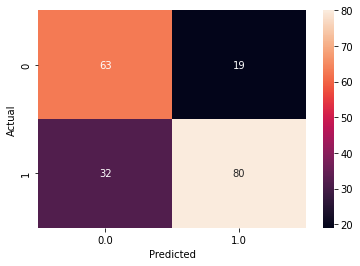

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

pan = predict_test.toPandas()
mat = pd.DataFrame(pan, columns=['account_type','prediction'])
confusion_matrix = pd.crosstab(pan['account_type'], pan['prediction'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

## Random Forest Model

In [ ]:
rf = RandomForestClassifier(labelCol="account_type", featuresCol="features", numTrees=10)
rf_model = rf.fit(train)
predict_train = rf_model.transform(train)
predict_test = rf_model.transform(test)
predict_test.select("account_type","prediction").show(10)

+------------+----------+
|account_type|prediction|
+------------+----------+
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
+------------+----------+
only showing top 10 rows



In [ ]:
tn = predict_test.select("account_type","prediction").filter(predict_test.account_type == 0).filter(predict_test.prediction == 0).count()
fp = predict_test.select("account_type","prediction").filter(predict_test.account_type == 0).filter(predict_test.prediction == 1).count()
fn = predict_test.select("account_type","prediction").filter(predict_test.account_type == 1).filter(predict_test.prediction == 0).count()
tp = predict_test.select("account_type","prediction").filter(predict_test.account_type == 1).filter(predict_test.prediction == 1).count()

In [ ]:
recall = tp/(fn+tp)
precision = tp/(fp+tp)
f1 = (2*recall*precision)/(recall+precision)
print("F1 Score is: ",f1)

F1 Score is:  0.8803827751196172


In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='account_type')
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.9340001297374441
The area under ROC for test set is 0.9055966898954704


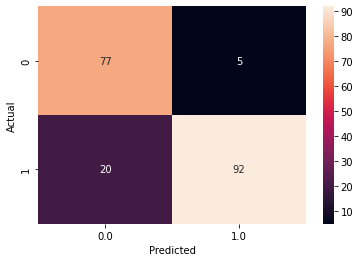

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

pan = predict_test.toPandas()
mat = pd.DataFrame(pan, columns=['account_type','prediction'])
confusion_matrix = pd.crosstab(pan['account_type'], pan['prediction'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

# Gradient-Boosted Tree Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [ ]:
gbt = GBTClassifier(maxIter=10, labelCol="account_type")
gbt_model = gbt.fit(train)
predict_train = gbt_model.transform(train)
predict_test = gbt_model.transform(test)

In [ ]:
tn = predict_test.select("account_type","prediction").filter(predict_test.account_type == 0).filter(predict_test.prediction == 0).count()
fp = predict_test.select("account_type","prediction").filter(predict_test.account_type == 0).filter(predict_test.prediction == 1).count()
fn = predict_test.select("account_type","prediction").filter(predict_test.account_type == 1).filter(predict_test.prediction == 0).count()
tp = predict_test.select("account_type","prediction").filter(predict_test.account_type == 1).filter(predict_test.prediction == 1).count()

In [ ]:
recall = tp/(fn+tp)
precision = tp/(fp+tp)
f1 = (2*recall*precision)/(recall+precision)
print("F1 Score is: ",f1)

F1 Score is:  0.878048780487805


In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='account_type')
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.9591124337122746
The area under ROC for test set is 0.9171929442508711


In [ ]:
predict_test.select("account_type","prediction").show(10)

+------------+----------+
|account_type|prediction|
+------------+----------+
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
+------------+----------+
only showing top 10 rows



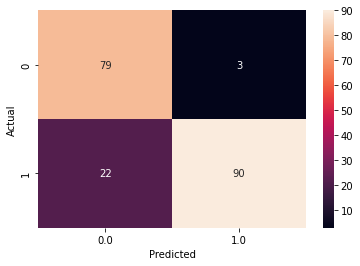

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

pan = predict_test.toPandas()
mat = pd.DataFrame(pan, columns=['account_type','prediction'])
confusion_matrix = pd.crosstab(pan['account_type'], pan['prediction'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

# Accessing user data from Twitter


In [ ]:
import json
import pandas

In [ ]:
jsonDF = spark.read.option("header","true").format("json").load("crypto.json")

In [ ]:
jsonDF.printSchema()
jsonDF.show()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- description: string (nullable = true)
 |-- id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- profile_image_url: string (nullable = true)
 |-- public_metrics: struct (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- following_count: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- tweet_count: long (nullable = true)
 |-- username: string (nullable = true)
 |-- verified: boolean (nullable = true)

+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------+
|                 _id|         description|                 id|            location|                name|   profile_image_url|      public_metrics|       username|verified|
+--------------------+--------------------+-------

In [ ]:
selectDF = jsonDF.select('id','description','location', 'name', col('profile_image_url').alias('default_profile'),\
                        col('public_metrics.followers_count').cast('int').alias('followers_count'), \
                        col('public_metrics.following_count').cast('int').alias('friends_count'))

In [ ]:
selectDF.printSchema()
selectDF.show(10,False)

root
 |-- id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- default_profile: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- friends_count: integer (nullable = true)

+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+---------------------+------------------------------------------------------------------------------+---------------+-------------+
|id                 |description                                                                                                                                                  |location                   |name                 |default_profile                                                               |followers_count|friends_count|
+-------------------+-

In [ ]:
finalDF = selectDF.withColumn('default_profile', \
                                when(selectDF.default_profile.contains('https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png'), 1)\
                                .otherwise(0))

In [ ]:
finalDF.printSchema()
finalDF.show()
finalDF.count()

root
 |-- id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- default_profile: integer (nullable = false)
 |-- followers_count: integer (nullable = true)
 |-- friends_count: integer (nullable = true)

+-------------------+--------------------+--------------------+--------------------+---------------+---------------+-------------+
|                 id|         description|            location|                name|default_profile|followers_count|friends_count|
+-------------------+--------------------+--------------------+--------------------+---------------+---------------+-------------+
|1523278026385068035|Akıcı insanca bil...|                null|        Özgün Gürbüz|              1|             28|           49|
|          285328602|       inexplainable|Hillside chillin ...|               James|              0|            381|          426|
|1544312647348207616|@0x_mytreasure an...| 

2910

## Get Bot predictions of the twitter data stored in the database

In [ ]:
def getDF(df):
    df.createOrReplaceTempView('df')
    return df.select(
    'followers_count', 'friends_count', 'default_profile',
      F.col("name").cast("string").contains("bot").alias("screen_name_binary"),
      F.col("description").cast("string").contains("bot").alias("description_name_binary"),\
    ).withColumn('bot_binary', F.col('screen_name_binary') | F.col('description_name_binary')).fillna({'bot_binary':False})\
    .select(col('bot_binary').cast('int'), 'followers_count', 'friends_count', 'default_profile')


In [ ]:
def getFeatures(train_df):
    cols=train_df.columns
    assembler = VectorAssembler(inputCols=cols,outputCol="features")
    train_df = assembler.transform(train_df)
    return train_df

In [ ]:
df = getDF(finalDF)
featuresDF = getFeatures(df) 
predict = rf_model.transform(featuresDF)

resultado = predict.select("bot_binary", "followers_count", "friends_count", "default_profile", "prediction","probability")
resultado.createOrReplaceTempView('df')
resultadoBot = spark.sql("Select count_if(prediction=1.0) as bots, count_if(prediction=0.0) as personas from df")
resultadoBot.show()

+----+--------+
|bots|personas|
+----+--------+
|1006|    1904|
+----+--------+



In [ ]:
resultadoPandas = resultado.toPandas()

resultadoPandas['prob humano'] = resultadoPandas.probability.apply(lambda x: x[0])
resultadoPandas['prob bot'] = resultadoPandas.probability.apply(lambda x: x[1])
resultadoPandas.drop(columns='probability')

,bot_binary,followers_count,friends_count,default_profile,prediction,prob humano,prob bot
0,0,28,49,1,1.0,0.396015,0.603985
1,0,381,426,0,0.0,0.876919,0.123081
2,0,64,189,0,0.0,0.864851,0.135149
3,0,321,4970,0,0.0,0.610543,0.389457
4,0,2,63,0,1.0,0.208591,0.791409
...,...,...,...,...,...,...,...
2905,0,3,25,0,1.0,0.493177,0.506823
2906,0,79,994,0,0.0,0.876919,0.123081
2907,0,36,4425,0,1.0,0.182614,0.817386
2908,0,102,265,0,0.0,0.864851,0.135149


In [ ]:
resultadoPandas.to_csv('cryptoResultado.csv', index=False)